In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets, interactive_output, Layout, VBox, HBox
from IPython.display import display
from cil.framework import AcquisitionGeometry, AcquisitionData, BlockDataContainer
from cil.processors import Normaliser, TransmissionAbsorptionConverter, Padder, CentreOfRotationCorrector, Binner, Slicer
import scipy

from cil.recon import FDK

from cil.optimisation.functions import IndicatorBox, L2NormSquared, BlockFunction
from cil.optimisation.algorithms import PDHG

from cil.utilities.dataexample import SANDSTONE
from cil.processors import Binner, Slicer
# Import FBP only after we disabled GPU
from cil.plugins.astra.processors import FBP

# CIL display tools
from cil.utilities.display import show2D

from cil.plugins.tigre import ProjectionOperator
from cil.plugins.astra import ProjectionOperator

import os
from cil.io import ZEISSDataReader, TIFFWriter
from cil.processors import TransmissionAbsorptionConverter, Slicer
from cil.recon import FDK
from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer, link_islicer

In [2]:
# remove some annoying warnings
import logging
logger = logging.getLogger('dxchange')
logger.setLevel(logging.ERROR)


New geometry:  3D Cone-beam tomography
System configuration:
	Source position: [   0.        , -105.05081177,    0.        ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ 0.        , 45.08757401,  0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [256 256]
	Pixel size: [0.26341718 0.26341718]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 1601
	Angles 0-9 in radians: [-3.1415665, -3.1377017, -3.1337626, -3.1298182, -3.125836 , -3.1219127,
 -3.1180956, -3.1140666, -3.1101887, -3.1062822]
	Angles 1591-1600 in radians: [3.106215 , 3.1101599, 3.1141102, 3.117992 , 3.12194  , 3.1258695,
 3.1298053, 3.1337383, 3.1376445, 3.1415997]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance
Shape out:  (1601, 256, 256)
New geometry shape:  (1601, 

  0%|          | 0/10 [00:00<?, ?it/s]

ROI for axis vertical has 'stop' out of bounds. Using axis length as stop value. Got stop index: 1596, using 256
ROI for axis horizontal_y has 'stop' out of bounds. Using axis length as stop value. Got stop index: 1596, using 256
ROI for axis horizontal_x has 'stop' out of bounds. Using axis length as stop value. Got stop index: 1596, using 256


New geometry:  Number of channels: 1
channel_spacing: 1.0
voxel_num : x251,y251,z251
voxel_size : x0.18431121826171873,y0.18431121826171873,z0.18431121826171873
center : x0.4607780456542968,y0.4607780456542968,z0.4607780456542968

Shape out:  (251, 251, 251)
New geometry shape:  (251, 251, 251)


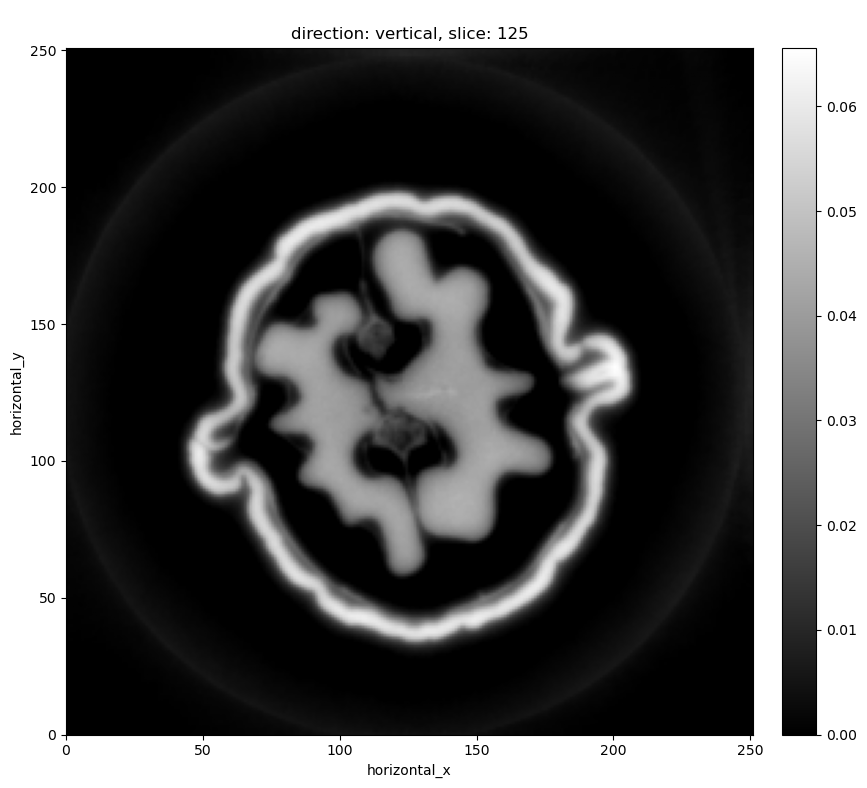

In [3]:
filename = "/home/maitrayee/CIL/valnut/valnut_2014-03-21_643_28/tomo-A/valnut_tomo-A.txrm"
data3D = ZEISSDataReader(file_name=filename).read()
# data3D.reorder('tigre')

binned_data3D = Binner(roi={'horizontal': (None, None, 4),
                            'vertical':   (None, None, 4)})(data3D)

absorption_data3D = TransmissionAbsorptionConverter()(binned_data3D)
# absorption_data3D -= np.mean(absorption_data3D.as_array()[80:100, 0:30])
# absorption_data3D.reorder('tigre') #TODO: for tigre in another script.
print('absorption_data3D shape', absorption_data3D.shape)

absorption_data3D.reorder("astra")   # modifies in place, returns None
walnut_cor = absorption_data3D  

background_counts = 10000
counts = background_counts * np.exp(-walnut_cor.as_array())
noisy_counts = np.random.poisson(counts)
walnut_noisy_data = -np.log(noisy_counts / background_counts)

walnut_noisy = walnut_cor.geometry.allocate()
walnut_noisy.fill(walnut_noisy_data)

ag = walnut_noisy.geometry
ig = ag.get_ImageGeometry()
# walnut_noisy.reorder('tigre')
# print("Generating FDK reconstruction...")
# recon_ground_truth = FDK(walnut_noisy, ig).run()
# show2D(recon_ground_truth)
# plt.savefig("/home/qsd31181/CIL-User-Showcase/015_Memory_Profiling_LSQR_CGLS/recon_FDK.png")
A = ProjectionOperator(ig, ag)
initial = ig.allocate(0)
padsize = 5
maxit = 10
itsAtATime = 1
N = round(maxit / itsAtATime)
xx = np.arange(0, maxit, itsAtATime)

g = IndicatorBox(lower=0)
f = L2NormSquared(b=walnut_noisy)
A = ProjectionOperator(ig, ag)
pdhg1 = PDHG(initial=ig.allocate(0), f=f, g=IndicatorBox(lower=0), operator=A)
pdhg1.run(10)  # try 300–500

padend = walnut_noisy.shape[1] - padsize
roi_xy = {'horizontal_x': (padsize, padend),
          'horizontal_y': (padsize, padend),
          'vertical':(padsize, padend)}
recon_ground_truth = Slicer(roi_xy)(pdhg1.solution)   # or FDK result
show2D(recon_ground_truth)



# recon_ground_truth = Slicer(roi_xy)(pdhg1.solution)
# show2D(recon_ground_truth)

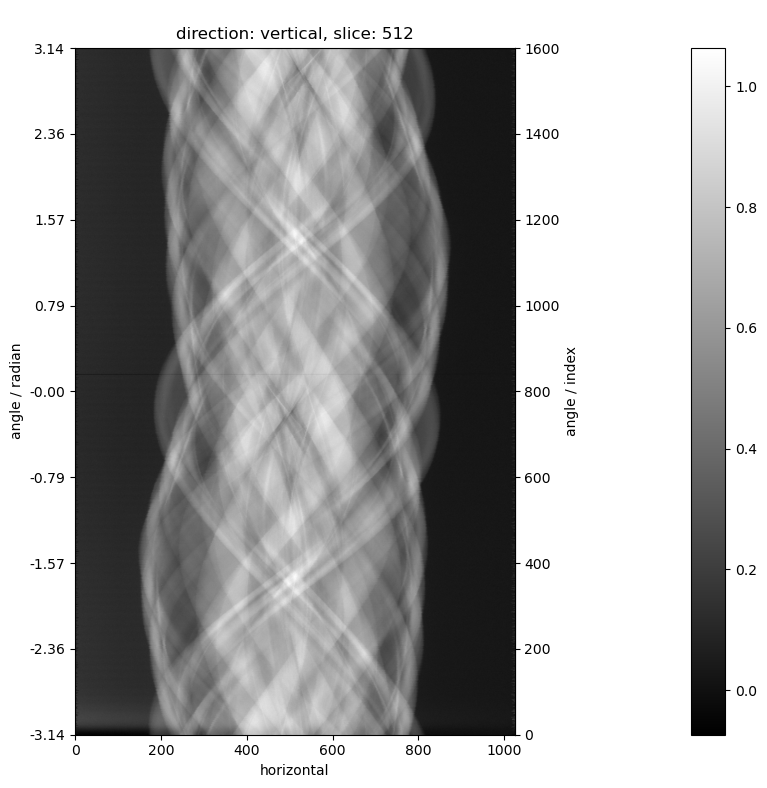

In [4]:
data = TransmissionAbsorptionConverter()(data3D)
islicer(data)
show2D(data, slice_list=('vertical', 512))

ROI for axis vertical has 'stop' out of bounds. Using axis length as stop value. Got stop index: 1596, using 256
ROI for axis horizontal_y has 'stop' out of bounds. Using axis length as stop value. Got stop index: 1596, using 256
ROI for axis horizontal_x has 'stop' out of bounds. Using axis length as stop value. Got stop index: 1596, using 256


New geometry:  Number of channels: 1
channel_spacing: 1.0
voxel_num : x251,y251,z251
voxel_size : x0.18431121826171873,y0.18431121826171873,z0.18431121826171873
center : x0.4607780456542968,y0.4607780456542968,z0.4607780456542968

Shape out:  (251, 251, 251)
New geometry shape:  (251, 251, 251)
Preview sizes: {<ImageDimension.VERTICAL: 'vertical'>: 251, <ImageDimension.HORIZONTAL_Y: 'horizontal_y'>: 251, <ImageDimension.HORIZONTAL_X: 'horizontal_x'>: 251}
Preview sizes: {<ImageDimension.VERTICAL: 'vertical'>: 251, <ImageDimension.HORIZONTAL_Y: 'horizontal_y'>: 251, <ImageDimension.HORIZONTAL_X: 'horizontal_x'>: 251}


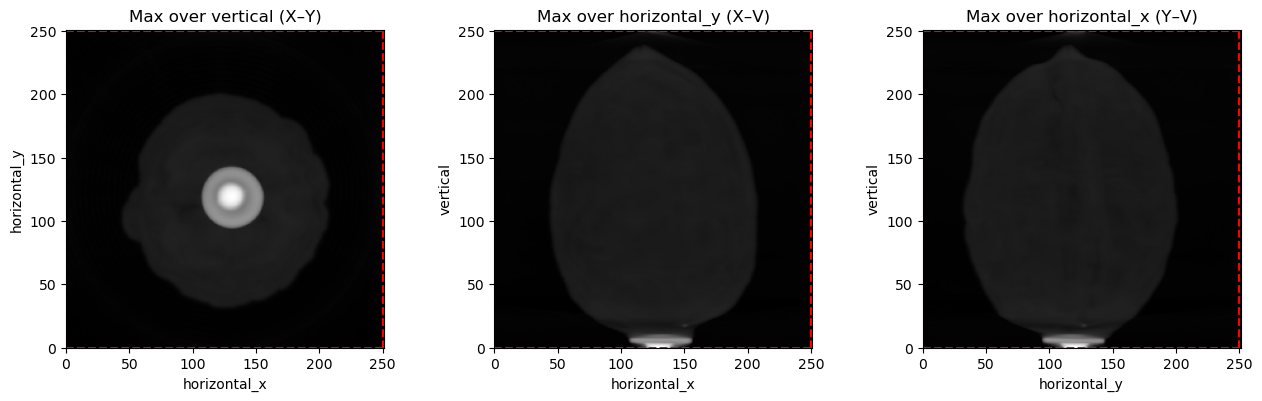

In [5]:
import importlib
import interactiveVolumeShrinker
importlib.reload(interactiveVolumeShrinker)
from interactiveVolumeShrinker import InteractiveVolumeShrinker

preview = Slicer(roi_xy)(pdhg1.solution)

dims  = list(preview.dimension_labels) 
sizes = {d: preview.get_dimension_size(d) for d in dims}
print("Preview sizes:", sizes)

ivs = InteractiveVolumeShrinker(
    absorption_data3D=absorption_data3D,
    preview=preview,
    roi_xy=roi_xy,
)

ivs.show()


In [6]:
print(InteractiveVolumeShrinker)
print(type(ivs))


<class 'interactiveVolumeShrinker.InteractiveVolumeShrinker'>
<class 'interactiveVolumeShrinker.InteractiveVolumeShrinker'>
